# Slide Riassuntiva Mensile

Questo Script calcola i numeri da inserire nella slide seguente (esempio)

<img src="immagine.png">

In [147]:
import pandas as pd
import iqos
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
#MAIN--ZONA DI INPUT!!!------------------------------
csv_name="/Users/ceriotticarlo/Desktop/Scaricato3Novembre.csv"
DF=pd.read_csv(csv_name,low_memory=False)
#Pulitura: coach valorizzato, Motivazione: togli num.tel.non valido e telesurvey_primo_contatto
DF=iqos.Ripulitura(DF)
#Splitta Data Contatto: crea 3 colonne nuove: Day, Month, Year
DF=iqos.Split_Data_in_Day_Month_Year(DF)
DF_completo=DF.copy()
#Filtra per data contatto: leggi come funziona funzione Estraction_based_on_dates con SHIFT+TAB
DF=iqos.Estraction_based_on_dates(1,3,1,4,DF)

## Calcolo dei numeri a sinistra (ELIGIBLE USERS)

In [53]:
#Eligible users by month
Eligible_Users_by_month=len(DF[DF['Progressivo_Follow_Up']==1])
print('Numero di Eligible users questo mese: {}'.format(Eligible_Users_by_month))

Numero di Eligible users questo mese: 286


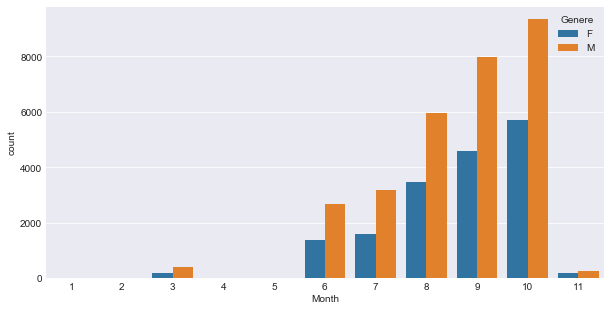

In [101]:
a=DF_completo[DF_completo['Progressivo_Follow_Up']==1]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax=sns.countplot(data=a,x='Month',hue='Genere')

## Calcolo Total Users

In [102]:
#Total eligible users: tutti da inizio
Eligible_totale=sum(DF_completo['Progressivo_Follow_Up']==1)
print('Numero totale di Eligible: {}'.format(Eligible_totale))

Numero totale di Eligible: 47215


## Calcolo del numero di messaggi scambiati

In [135]:
#Numero di messaggi
Num_mess=DF['Numero_messaggi_scambiati'].astype(float).copy()
Num_mess=Num_mess[Num_mess.between(4,100)]
Num_mess=Num_mess.mean()+1
print('Numero di messaggi scambiati: {}'.format(Num_mess))

Numero di messaggi scambiati: 10.18407960199005


## Interaction Funnel

In [ ]:
#Generazione dei Funnels
import sys
import pandas as pd
import numpy as np
import pdb
import math

def Pulitura_DF(DF,Skip=None):
    #pdb.set_trace()
    DF=DF[['User_ID','Progressivo_Follow_Up','Risultato_contatto_Whatsapp','Utente_Convertito','TIPOLOGIA_UTENTE']] #prendo le righe che mi servono
    DF.User_ID=DF.User_ID.astype(str) #Trasformo in stringa tutto
    DF.Progressivo_Follow_Up=DF.Progressivo_Follow_Up.astype(str)
    DF.Risultato_contatto_Whatsapp=DF.Risultato_contatto_Whatsapp.astype(str)
    DF.Utente_Convertito=DF.Utente_Convertito.astype(str)

    DF=DF[DF.Utente_Convertito != 'Light'] #Scarto le righe che contengono light
    DF=DF[DF.Progressivo_Follow_Up != 'Spontaneo'] #Scarto le righe che hanno Spontaneo come N_Contatto

    #Mapping per inasattezze RISPOSTA
    #Infatti, la colonna Risposta contiene il SI e NO scritto in molti modi
    #Allora con map posso cambiarli tutti in NO e SI, in questo modo ho solo 2 tipi di risposta
    risposte={'SI':'SI','No':'NO','no':'NO','Sì':'SI','NO':'NO'}
    #DF['Risultato_contatto_Whatsapp']=DF['Risultato_contatto_Whatsapp'].map(risposte)
    DF['Utente_Convertito']=DF['Utente_Convertito'].map(risposte)
    risposte2={'Ha visualizzato e interagito':'SI',
                'Ha visualizzato ma non ha interagito':'NO',
                'Non ha visualizzato':'NO'}
    DF['Risultato_contatto_Whatsapp']=DF['Risultato_contatto_Whatsapp'].map(risposte2)

    #pdb.set_trace()
    DF=DF[DF['TIPOLOGIA_UTENTE']!='UTENTI DELAYED'] #Tolgo gli utenti delayed se ce ne fossero
    return(DF)

def Calc_Funnel(DF,Step,User_id=None):

    DF2=DF.copy()
    if (Step!='1'):
        DF=DF[((DF['Progressivo_Follow_Up']==Step) & (DF['User_ID'].isin(User_id)))]

    #STEP 1
    #INTERACTING USERS_1
    #Num di utenti che rispondono al primo contatto
    #Gli interacting users sono quelli che rispondono
    Rows_Int=np.where((DF['Progressivo_Follow_Up']==Step) & (DF['Risultato_contatto_Whatsapp']=='SI'))
    Num_Int=len(Rows_Int[0]) #Numero di interacting users

    if Num_Int==0:
        pdb.set_trace()
        print('Tutto 0')
        return()

    Denominatore_Int_users=np.where((DF['Progressivo_Follow_Up']==Step) & ((DF['Risultato_contatto_Whatsapp']=='SI') | (DF['Risultato_contatto_Whatsapp']=='NO') | (DF['Risultato_contatto_Whatsapp'].isnull())))
    Denominatore_Int_users=len(Denominatore_Int_users[0]) #Denominatore per calcolare la % di interac.users

    # % degli utenti interacting
    #pdb.set_trace()
    Ratio_Int=(Num_Int/Denominatore_Int_users)*100

    #Salvo in un dataframe a parte SOLO gli interactive users
    DF_Int=DF.iloc[Rows_Int] #Rows_Int_1 contiene gli indici di interactive users

    #CONVERTED

    #Utenti dichiarati convertiti - Declared Conversion
    Rows_Conv=np.where(DF_Int['Utente_Convertito']=='SI')
    Num_Conv=len(Rows_Conv[0])

    Denominatore_Converted=np.where((DF_Int['Utente_Convertito']=='SI') | (DF_Int['Utente_Convertito']=='NO') | (DF_Int['Utente_Convertito'].isnull()) )
    Denominatore_Converted=len(Denominatore_Converted[0])
    Ratio_Conv=(Num_Conv/Denominatore_Converted)*100

    #IN CONVERSION
    Rows_InConv=np.where((DF_Int['Utente_Convertito'].isnull())|(DF_Int['Utente_Convertito']=='NO'))
    Num_InConv=len(Rows_InConv[0])
    Denominatore_InConv=Denominatore_Converted
    Ratio_InConv=(Num_InConv/Denominatore_InConv)*100

    print('Step%s: Perc.Interacting %.2f, Perc.Converted %.2f,  Perc.InConversion %.2f' % (Step,Ratio_Int,Ratio_Conv,Ratio_InConv))
    #pdb.set_trace()
    #Ora che ho stampato i risultati per il primo step, devo passare i dati giusti per lo step2
    #Sopravvivono solo gli utenti IN CONVERSION

    #pdb.set_trace()
    Rows_InConv=(((DF2['Utente_Convertito'].isnull())) & (DF2['Progressivo_Follow_Up']==Step) & (DF2['Risultato_contatto_Whatsapp']=='SI'))
    User_ID_InConv=DF2[Rows_InConv]['User_ID']
    User_ID_InConv=list(User_ID_InConv)

    return(User_ID_InConv)


#MAIN
DF=Pulitura_DF(DF)
User_ID_InConv_1=Calc_Funnel(DF,'1')
User_ID_InConv_2=Calc_Funnel(DF,'2',User_ID_InConv_1)
User_ID_InConv_3=Calc_Funnel(DF,'3',User_ID_InConv_2)
User_ID_InConv_4=Calc_Funnel(DF,'4',User_ID_InConv_3)

> <ipython-input-152-5bd2918ff725>(49)Calc_Funnel()
-> print('Tutto 0')
(Pdb) Num_int
*** NameError: name 'Num_int' is not defined
(Pdb) Num_Int
0
(Pdb) DF['Progressivo_Follow_Up']==Step
150631     True
150633     True
150634     True
150635     True
150636     True
150637     True
150638     True
150639     True
150640     True
150641     True
150642     True
150643     True
150644     True
150645     True
150646     True
150648     True
150649     True
150652     True
150653     True
150654     True
150658     True
150659     True
150660     True
150662     True
150663     True
150664     True
150665     True
150666     True
150667     True
150672     True
          ...  
213852    False
213858    False
213861    False
213873    False
213876    False
213877    False
213902    False
213903    False
213961    False
213971    False
213977    False
213979    False
214002    False
214020    False
214024    False
214048    False
214057    False
214069    False
214082    False
214088    Fal

## Calcolo del Funnel (colonna centrale): INTERACTION LEVEL

## HYPERCARE KPI